# 11/18/19

I finished up experiments with the catheter detector dataset. It looks promising so far. Here I will generate some figures regarding their performance. Then I will start exploration of the MIMIC dataset.

In [11]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('/lfs/1/gangus/repositories/pytorch-classification/drain_detector')
import os.path as osp
import re
import json
import pickle

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def plot_learning_curves(name, experiment_dirs, splits, metric, ylim=None):
    res = plt.subplots(len(experiment_dirs))
    fig, axs = res[0], res[1:][0]
    if not isinstance(axs, np.ndarray):
        axs = [axs]
    fig.set_figheight(len(experiment_dirs) * 5)
    fig.set_figwidth(10)
    fig.suptitle(f'{name}: learning curves ({metric})')
    for experiment_idx, experiment_dir in enumerate(experiment_dirs):
        fig1_data = []
        cout_path = osp.join(experiment_dir, 'cout.txt')
        with open(cout_path, 'r') as f:
            line = f.readlines()[0]
            path_idx = re.search('Setting logging directory to: ', line).span()[1]
            log_path = osp.join(line[path_idx:-1], 'emmental.log')
        with open(log_path, 'r') as f:
            lines = f.readlines()
            for split in splits:
                query = f"{split}/{metric}': "
                primary_metric_str = re.findall(f"{query}[0-9\.]+", "\n".join(lines)) # guaranteed to be in order
                primary_metric_vals = [s[len(query):] for s in primary_metric_str]
                print(f'{split} max {metric}: {max(primary_metric_vals, key=lambda x: float(x))}')
                for epoch, val in enumerate(primary_metric_vals):
                    fig1_data.append({
                        'split': split,
                        'epoch': epoch,
                        'metric': metric,
                        'query': query,
                        f'{metric}': float(val),
                        'experiment_dir': experiment_dir,
                        'experiment_name': name
                    })
        fig1_df = pd.DataFrame(fig1_data)
        ax = axs[experiment_idx]
        if ylim:
            ax.set_ylim(ylim)
        sns.lineplot(data=fig1_df, x='epoch', y=f'{metric}', hue='split', ax=ax)
    return fig

In [32]:
experiment_dirs = [
    'experiments/drain_detection/cxr_only/no_pretrain/1',
    'experiments/drain_detection/cxr_only/pretrain_imagenet/1',
    'experiments/drain_detection/cxr_only/pretrain_chexnet/1',
    'experiments/drain_detection/cxr_seg/no_pretrain/1',
    'experiments/drain_detection/cxr_seg/pretrain_imagenet/2',
    'experiments/drain_detection/cxr_seg/pretrain_chexnet/1'
]

train max f1: 0.8706365503080082
valid max f1: 0.7499999999999999


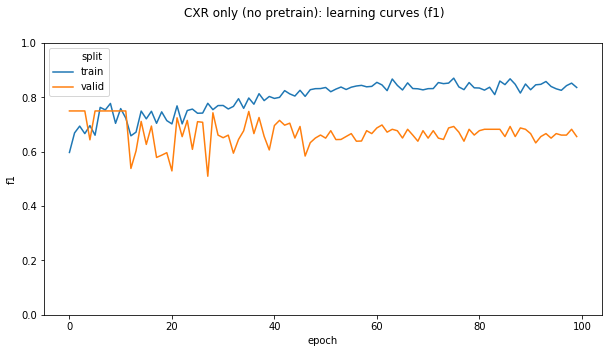

In [41]:
name = 'CXR only (no pretrain)'
splits = ['train', 'valid']
metric = 'f1'
ylim = [0,1]
fig = plot_learning_curves(name, [experiment_dirs[0]], splits, metric, ylim)
fig.savefig(f"figs/{name.replace(' ', '_')}.png")

train max f1: 0.8741044012282497
valid max f1: 0.7969924812030076


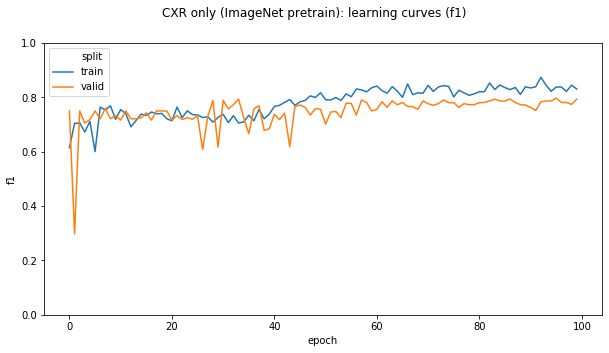

In [42]:
name = 'CXR only (ImageNet pretrain)'
splits = ['train', 'valid']
metric = 'f1'
ylim = [0,1]
fig = plot_learning_curves(name, [experiment_dirs[1]], splits, metric, ylim)
fig.savefig(f"figs/{name.replace(' ', '_')}.png")

train max f1: 0.9968387776606955
valid max f1: 0.7972972972972971


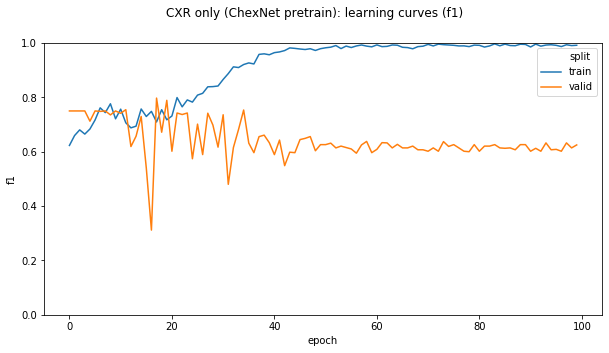

In [43]:
name = 'CXR only (ChexNet pretrain)'
splits = ['train', 'valid']
metric = 'f1'
ylim = [0,1]
fig = plot_learning_curves(name, [experiment_dirs[2]], splits, metric, ylim)
fig.savefig(f"figs/{name.replace(' ', '_')}.png")

train max f1: 1.0
valid max f1: 0.9137931034482758


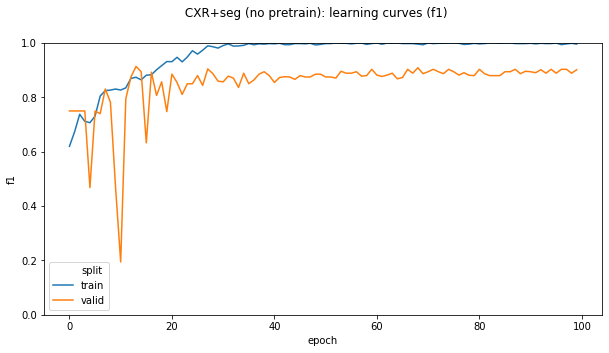

In [44]:
name = ' CXR+seg (no pretrain)'
splits = ['train', 'valid']
metric = 'f1'
ylim = [0,1]
fig = plot_learning_curves(name, [experiment_dirs[3]], splits, metric, ylim)
fig.savefig(f"figs/{name.replace(' ', '_')}.png")

train max f1: 0.9979253112033196
valid max f1: 0.9206349206349207


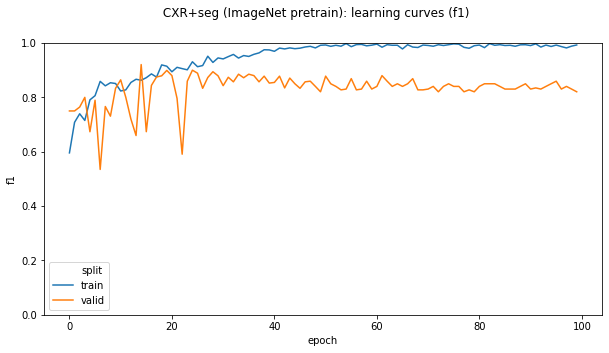

In [45]:
name = ' CXR+seg (ImageNet pretrain)'
splits = ['train', 'valid']
metric = 'f1'
ylim = [0,1]
fig = plot_learning_curves(name, [experiment_dirs[4]], splits, metric, ylim)
fig.savefig(f"figs/{name.replace(' ', '_')}.png")

train max f1: 1.0
valid max f1: 0.9421487603305784


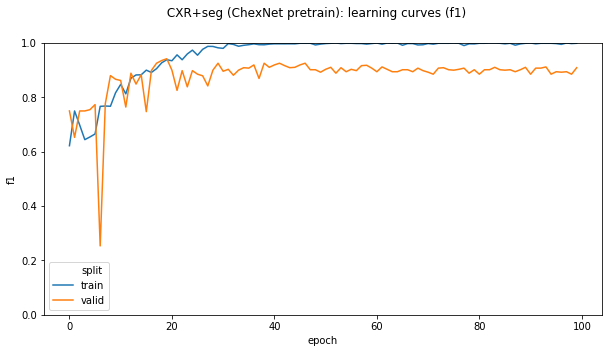

In [46]:
name = ' CXR+seg (ChexNet pretrain)'
splits = ['train', 'valid']
metric = 'f1'
ylim = [0,1]
fig = plot_learning_curves(name, [experiment_dirs[5]], splits, metric, ylim)
fig.savefig(f"figs/{name.replace(' ', '_')}.png")

# MIMIC Exploration

In [100]:
study_dir = '/lfs/1/gangus/data/mimic/reports'
study_df = pd.read_csv(osp.join(data_dir, 'cxr-study-list.csv'))

In [101]:
study_df.keys()

Index(['subject_id', 'study_id', 'path'], dtype='object')

In [111]:
from pprint import PrettyPrinter
printer = PrettyPrinter(width=120)

In [113]:
# for i in range(10):
#     study_row = study_df.iloc[10]
#     with open(osp.join(study_dir, study_row['path']), 'r') as f:
#         study = f.readlines()
#     printer.pprint(study)